# **Solução do problema**

-- Objetivo do problema:
    -- Previsão do 1º destino que um novo usuário irá escolher.
    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb
            -- Marketplace (Conecta pessoas que oferecem acomodação com pessoas que procuram acomodação)
            -- Oferta (Pessoas oferecendo acomodacao)
                -- Tamanho do portfólio
                -- Diversidade/Densidade de portfólio
            -- Demanda (Pessoas procurando acomodacao)
                -- Número de usuários
                -- LTV (Life Time Value)
                -- CAC (Client Aquisition Cost)
                
    > Gross Revenue = (Preco medio * numero de cliente) - CAC
            
-- Proposta da solucao:
    -- Modelo de previsao do primeiro destino de um usuário
        -- Predicoes e salvar em tabela no banco de dados
        -- API
            -- Input: usuario e caracteristicas
            -- Output: usuarios, caracteristicas e *predicao do destino*

# 0.0 Imports

In [89]:
import pandas as pd

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from keras      import models          as ml
from keras      import layers          as l

## 0.1 Helper Functions

## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('../datasets/train_users_2.csv', low_memory=True)

In [5]:
df_sessions = pd.read_csv('../datasets/sessions.csv', low_memory=True)

# 1.0 Data Description

In [19]:
df1 = df_raw.copy()

## 1.1 Users:

In [20]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [22]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 213451
Número de colunas: 16


### 1.1.1 Data type

In [23]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [27]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])
# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
# age
df1['age'] = df1['age'].astype(int)

### 1.1.2 Check NA

In [28]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [ ]:
# date_first_booking

# age

# first_affiliate_tracked

In [29]:
df1 = df1.dropna()

In [30]:
df1.shape

(68171, 16)

### 1.1.3 Check Balanced Data

In [31]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## 1.2 Sessions:

In [12]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [14]:
df_sessions[df_sessions['user_id'] == 'd1mm9tcy42'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
d1mm9tcy42,126


In [16]:
df_sessions[df_sessions['user_id'] == 'd1mm9tcy42'][['user_id', 'action']].value_counts()

user_id     action                     
d1mm9tcy42  show                           28
            personalize                    25
            lookup                         23
            search_results                 12
            index                          11
            similar_listings                9
            ajax_refresh_subtotal           8
            hosting_social_proof            2
            active                          1
            ask_question                    1
            decision_tree                   1
            faq_experiment_ids              1
            header_userpic                  1
            multi                           1
            other_hosting_reviews_first     1
            recent_reservations             1
dtype: int64

# 2.0 Data Filtering

In [32]:
df2 = df1.copy()

## 2.1 Filtering Rows

## 2.2 Columns Selection

# 3.0 Data Preparation

In [57]:
df3 = df2.copy()

In [59]:
# dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id','country_destination'], axis=1))

# join 'id' and 'country destination'
df3 = pd.concat([df3[['id','country_destination']], df3_dummy], axis=1)

In [61]:
df3.head()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,US,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
7,0d01nltbrs,US,2010-01-03,2010-01-03 19:19:05,2010-01-13,47,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


# 4.0 Feature Selection

In [62]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'id']
df4 = df3.drop(cols_drop, axis=1)

In [63]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

# 5.0 Machine Learning Model - Neural Network (MLP)

In [64]:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [65]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [67]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model train
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.3400 - accuracy: 0.7056
Epoch 2/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.2808 - accuracy: 0.7072
Epoch 3/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2504 - accuracy: 0.7080
Epoch 4/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.2234 - accuracy: 0.7081
Epoch 5/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2042 - accuracy: 0.7084
Epoch 6/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.1893 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1730 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1646 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1566 - accuracy: 0.7086
Epoch 10/100
1705/1705 [==============================] - 8s 5ms/step - l

# 6.0 NN Performance

In [86]:
# prediction
pred_nn = model.predict(X_val)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

427/427 [==============================] - 1s 1ms/step


Accuracy: 0.7028969563623029


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

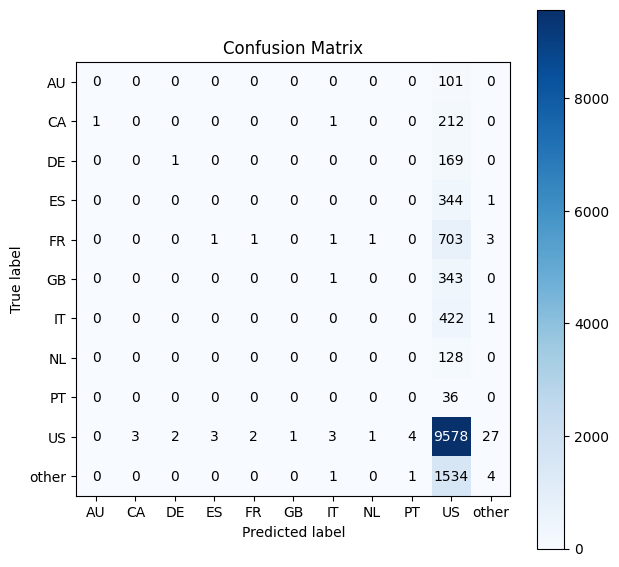

In [94]:
# accuracy
acc_nn = m.accuracy_score(y_val_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_val_nn, yhat_nn, normalize=False, figsize=(7,7))

# Precision


# Recall


# F1-Score

